# Signal Processing (LSTM Training)

Now that we have the data processed properly the challenge will be to design, train and test the Long Short-Term Memory (LSTM) network to predict the classifications we have previously extracted.

For reference here is the image again of the full Deep Deterministic Policy Gradient (DDPG) Reinforcement Learning (RL) architecture we are trying to build.  Please see the full [2nd report](docs/report2.pdf) for a complete description of this network.

![DDPG](docs/ddpg.png "DDGP")

As you can see there is a LSTM in both the actor and critic networks.  Before the full DDPG can be implemented we must confirm that the LSTM can provide satisfactory signals or the DDPG will just be running on noise.

## 1. Load some necessary modules

In [78]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import yaml

%matplotlib inline

## 1. Load and encode the timeseries data 
Each data _point_ at time `t` is actually a series of `k` standardized return values from `t-k` to `t` (`x`) and an array of classifications for each `dt` in `prediction_days` (`y`).  Therefore each data point is treated as independent events and will be processed in a random order.  So our first task is to properly structure the timeseries data into indepentent events.

Here is an illustration of this transformation for a single asset with two different number of time values.

![embedding](docs/embedding.png "embedding")

Load the previously saved data and unpack it into Numpy arrays.

In [79]:
with open('settings.yml') as f:
    settings = yaml.safe_load(f)

In [80]:
with open('training-data-raw.pkl', 'rb') as f:
    data = pickle.load(f)
dt_values = list(data['y'].keys())
assets = data['x'][dt_values[0]].columns.tolist()
assets.remove(settings['sp500'])
dates = data['x'][dt_values[0]].index.tolist()

### 1.1 Process the input data `x` and targets `y`
The input `x` to the LSTM network has to have the dimensions [batch_size, time_embedding (k), n_features].  The batch size will be processed later but it is the number of points to feed the network in a single batch.  The number of features in this implementation will be the number of time horizons used to calculate the returns for both the asset to model and also the S&P index.    
The output `y` is simply the number of points in the batch and the number of prediction days we will try to predict.    
Note for both `x` and `y` there is another dimension not shown for the number of assets to model.  In this implementation the assets will be modeled independently.  Effectively we are ignoring the coupling between assets during the performance prediction.  Once we integrate this into the DRL algorithm, all of these independent signals will be feed into the DRL network.   
The S&P signal will be stacked onto the 3rd dimension before training. 
![shape](docs/data-shape.png "shape")

In [125]:
k = settings['embedding_days']
n_t = len(dates) - k + 1

# Process x and y
x = np.empty((n_t, k, len(dt_values), len(assets)))
y = np.empty((n_t, len(dt_values), len(assets)))
for i_a, asset in enumerate(assets):
    for i_dt, dt in enumerate(dt_values):
        y[:, i_dt, i_a] = data['y'][dt].loc[:, asset].values[(k-1):]
        for i_n in range(n_t):
            x[i_n, :, i_dt, i_a] = data['x'][dt].loc[:, asset].values[i_n:(i_n+k)][::-1]

# Process the asset representing the S&P 500 index
sp500 = np.empty((n_t, k, len(dt_values), 1))
for i_dt, dt in enumerate(dt_values):
    for i_n in range(n_t):
        sp500[i_n, :, i_dt, 0] = data['x'][dt].loc[:, settings['sp500']].values[i_n:(i_n+k)][::-1]
        
# Stack the S&P onto x
print(x.shape)
print(sp500.shape)
x = np.concatenate((x, np.concatenate((sp500, sp500), axis=3)), axis=2)
print(x.shape)
del sp500
print(np.max(np.abs((x[:, :, 3:, 0] - x[:, :, 3:, 1]))))

(2918, 63, 3, 2)
(2918, 63, 3, 1)
(2918, 63, 6, 2)
0.0


### 1.2 Process the target values `y`

In [126]:
print("{} assets.".format(x.shape[3]))
print("{} total time points.".format(x.shape[0]))
print("{} time embedding length (k).".format(x.shape[1]))
print("{} prediction horizons (n_dt).".format(y.shape[1]))

2 assets.
2918 total time points.
63 time embedding length (k).
3 prediction horizons (n_dt).


## 2. Split data into training, validation and testing sets
The `test` set is not used during the training and is only used at the very end to evaluate how well the LSTM can predict unseen data.  For our purposes we defined the `test` set as data from the period from the `training_end` date defined in the settings file to the end of our processed data.

The `train` set is the data actually used to traing the LSTM where as the `val` set isn't directly used to traing the LSTM but is used to evaluate the training process after each training epoch.  After each epoch we evaluate the model against the `train` and `val` set.  We will continue to train as long as both the `train` and `val` errors decay, but we must stop if the `val` error begins to rise.  A falling `train` error but rising `val` error indicates the model is starting to overfit the training data.  A good description of overfitting is contained in this [wiki page](https://en.wikipedia.org/wiki/Overfitting).

We will follow the stardard practice of splitting our non-test data 9-1 between the `train` and `val` sets.  Note also that we are randomizing the data within the `train` and `val` sets to emilinate any temporal biases.

### Perform the split

In [128]:
n_test_days = np.sum(np.array(dates) >= pd.Timestamp(settings['training_end']))

# Test data is simply all the data after the 'training_end' date.
x_test = x[-n_test_days:, :, :]
y_test = y[-n_test_days:, :, :]

# Extract the train and val data and then randomly split 9/1
x_train, x_val, y_train, y_val = train_test_split(x[:-n_test_days, :, :, :], 
                                                  y[:-n_test_days, :, :], 
                                                  test_size=0.1)

Data is now ready, let the real fun begin....

## 3. Define the LSTM network
Please see the PyTorch LSTM [documentation](https://pytorch.org/docs/stable/nn.html#lstm) for more detail.    

A special thanks for this component goes to the Udacity Deep Learning [Nanodegree](https://www.udacity.com/course/deep-learning-nanodegree--nd101).  Much of this content was derived from the Nanodegree projects.

### 3.1 Check to see if running on a GPU

In [129]:
train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda" if train_on_gpu else "cpu")
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; ouch, consider making n_epochs very small.')

No GPU available, training on CPU; ouch, consider making n_epochs very small.


### 3.2 Define the LSTM network

In [164]:
import torch.nn as nn
import torch.nn.functional as nn_f

class LSTM(nn.Module):
    
    def __init__(self, n_features, n_output, n_layers=1, n_hidden=500, dropout=0.2):
        """
        Initialize the PyTorch LSTM Module plus a linear layer to perform the regression classification.
        
        Args:
            n_features (int): The number of input dimensions
            n_output (int): The number prediction horizons
            n_layers (int): Number of LSTM layers
            n_hidden (int): Number of hidden nodes in the LSTM layers
            dropout (float): dropout to add in between LSTM/GRU layers
        """
        
        super(LSTM, self).__init__()
        
        # Set class attributes
        self.n_features = n_features
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_output = n_output
        
        # Define the LSTM
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=n_hidden, num_layers=n_layers, 
                            batch_first=True, dropout=dropout)
        
        # Linear fully-connected feed forward network
        self.fc1 = nn.Linear(n_hidden, int((n_hidden + n_output) / 2.0))
        self.fc2 = nn.Linear(int((n_hidden + n_output) / 2.0), n_output)
        
        
    def forward(self, x, hidden):
        """
        Forward propagation of the neural network
        
        Args:
            x (tensor): [batch_size, k, n_feature] The input to the neural network
            hidden (tuple of tensor): The previous hidden state
        
        Returns:
            tensor:  [self.output_size] Ouput of the network
            tuple of tensor:  (h_n, c_n) The latest hidden state
        """

        # Read the batch size
        batch_size = x.size(0)

        # Get LSTM outpout and updated hidden state
        out, hidden = self.lstm(x, hidden)
    
        # Stack up lstm outputs
        out = out.contiguous().view(-1, self.n_hidden)

        # Feed through fully-connected layer
        out = nn_f.relu(self.fc1(out))
        out = self.fc2(out)
        
        # Reshape to be batch_size first
        out = out.view(batch_size, -1, self.n_output)
        out = out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        '''
        Initialize the hidden state of an LSTM/GRU
        
        Args:
            batch_size: The batch_size of the hidden state
        
        Returns:
            tuple of int:  hidden state of dims (n_layers, batch_size, n_hidden)
        '''
        # Initialize hidden state with zero weights, and move to GPU if available
        
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().float().cuda(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().float().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().float(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().float())
        
        return hidden

### 3.3 Define the forward and backpropagation steps

In [165]:
def forward_back_prop(lstm, optimizer, criterion, inp, target, hidden, clip=5.0):
    """
    Forward and backward propagation on the neural network
    
    Args:
        lstm (LSTM): The LSTM object
        optimizer: The PyTorch optimizer for the neural network
        criterion: The PyTorch loss function
        inp (tensor): [batch_size, k, n_feature] The input to the neural network
        target (tensor): [batch_size, n_dt * n_output] The neural network output
        hidden (tuple of tensor): The previous hidden state
        clip (float):  Value to clip gradients to avoid exploding LSTM gradients
    
    Returns:
        float: The loss for the last training batch item
        tuple of tensor:  (h_n, c_n) The latest hidden state
    """
    
    if(train_on_gpu):
        inp, target = inp.cuda(), target.cuda()
 
    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    hidden = tuple([each.data for each in hidden])
    
    # Zero accumulated gradients
    lstm.zero_grad()
    
    # Perform forward propagations, loss calculation and back propagation
    output, hidden = lstm(inp, hidden)
    loss = criterion(output, target)
    loss.backward()
    
    # Clip the gradients and then perform the weight optimization
    nn.utils.clip_grad_norm_(lstm.parameters(), clip)
    optimizer.step()

    return loss.item(), hidden

In [166]:
def train_lstm(lstm, batch_size, optimizer, criterion, n_epochs, min_v_loss=1.0):
   
    print("Training for %d epoch(s)..." % n_epochs)
    message = 'Epoch: {:>4} Loss: {:.3f}, V-Loss: {:.3f}, V-Error {:.3f}'
    for epoch_i in range(1, n_epochs + 1):
        lstm.train()
        batch_losses = []

        # initialize hidden state
        hidden = lstm.init_hidden(batch_size)
        
        for batch_i, (inputs, labels) in enumerate(train_loader, 1):
            
            # make sure you iterate over completely full batches, only
            n_batches = len(train_loader.dataset)//batch_size
            if(batch_i > n_batches):
                break
            
            # forward, back prop
            loss, hidden = forward_back_prop(lstm, optimizer, criterion, inputs, labels, hidden)          
            # record loss
            batch_losses.append(loss)

        # printing loss and validation stats
        lstm.eval()
        val_losses = []
        val_errors = []
        for batch_i, (inputs, labels) in enumerate(val_loader, 1):
            # make sure you iterate over completely full batches, only
            n_batches = len(val_loader.dataset)//batch_size
            if(batch_i > n_batches):
                break

            output, hidden = lstm(inputs, hidden)
            val_losses.append(criterion(output, labels).item())
            val_errors.append(torch.abs(labels - output).mean().item())
            
        v_loss = np.average(val_losses)
        if v_loss < min_v_loss:
            min_v_loss = v_loss
            torch.save(lstm.state_dict(), 'lstm_vloss_{:.3f}.pth'.format(v_loss))
        print(message.format(epoch_i, np.average(batch_losses), v_loss, np.average(val_errors)))

    return lstm

### Let's train an asset as a test of the system

#### First reduce the data

Projected 1-Day outlook is Very bad.
Projected 7-Day outlook is Very bad.


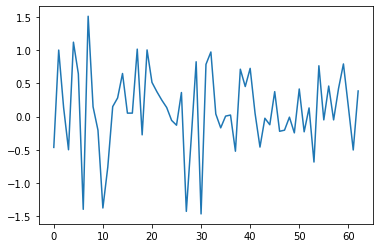

In [167]:
asset_number = 0
batch_size = 200

# Slice the assets from x and stack the dt and n_assets for y
tmp_x = torch.from_numpy(x_train[:, :, :, asset_number]).float().to(device)
tmp_y = torch.from_numpy(y_train[:, :, asset_number]).float().to(device)
train_loader = DataLoader(TensorDataset(tmp_x, tmp_y), shuffle=True, batch_size=batch_size)

# Do the same for the verification and test sets
tmp_x = torch.from_numpy(x_val[:, :, :, asset_number]).float().to(device)
tmp_y = torch.from_numpy(y_val[:, :, asset_number]).float().to(device)
val_loader = DataLoader(TensorDataset(tmp_x, tmp_y), shuffle=True, batch_size=batch_size)

tmp_x = torch.from_numpy(x_test[:, :, :, asset_number]).float().to(device)
tmp_y = torch.from_numpy(y_test[:, :, asset_number]).float().to(device)
test_loader = DataLoader(TensorDataset(tmp_x, tmp_y), shuffle=True, batch_size=batch_size)
del tmp_x, tmp_y

# Print a batch to test
data_iter = iter(train_loader)
sample_x, sample_y = data_iter.next()
decoder = {0.0: 'Very bad', 0.25: 'Bad', 0.5: 'Neutral', 0.75: 'Good', 1.0: 'Very good'}
print("Projected 1-Day outlook is {}.".format(decoder[sample_y[0, 0].item()]))
print("Projected 7-Day outlook is {}.".format(decoder[sample_y[0, 1].item()]))
plt.plot(sample_x[0, :, 0])
plt.show()


#### Defined the hyper-parameters and instantiate the model

In [168]:
# Defined the hyper-parameters
n_layers = 4
n_hidden = 500
dropout = 0.1

# create model and move to gpu if available
lstm = LSTM(n_features=x.shape[2], n_output=y.shape[1],
            n_layers=n_layers, n_hidden=n_hidden, dropout=dropout)
if train_on_gpu:
    lstm.cuda()

#### Train the model

In [ ]:
n_epochs = 100
learning_rate = 0.0001
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Load a previously trained model
min_v_loss = 1.0
model_name = 'na'
for name in glob('lstm_vloss_*.pth'):
    try:
        v_loss = float(name[11:-4])
    except:
        pass
    else:
        if v_loss < min_v_loss:
            min_v_loss = v_loss
            model_name = name
if model_name != 'na':
    try:
        saved_lstm = LSTM(n_features=x.shape[2], n_output=y.shape[1],
                          n_layers=n_layers, n_hidden=n_hidden, dropout=dropout)
        saved_lstm.load_state_dict(torch.load(model_name))
    except:
        min_v_loss = 1.0
    else:
        lstm = saved_lstm
        print('Starting from saved model with validation loss of {:.3f}'.format(min_v_loss))
    
# Restart the training
lstm = train_lstm(lstm, batch_size, optimizer, criterion, n_epochs, min_v_loss)

Starting from saved model with validation loss of 0.096
Training for 100 epoch(s)...
Epoch:    1 Loss: 0.093, V-Loss: 0.101, V-Error 0.266
Epoch:    2 Loss: 0.094, V-Loss: 0.098, V-Error 0.259
Epoch:    3 Loss: 0.093, V-Loss: 0.102, V-Error 0.267
Epoch:    4 Loss: 0.094, V-Loss: 0.097, V-Error 0.260
Epoch:    5 Loss: 0.093, V-Loss: 0.098, V-Error 0.261
Epoch:    6 Loss: 0.093, V-Loss: 0.101, V-Error 0.265
Epoch:    7 Loss: 0.094, V-Loss: 0.100, V-Error 0.263
Epoch:    8 Loss: 0.094, V-Loss: 0.100, V-Error 0.263
Epoch:    9 Loss: 0.094, V-Loss: 0.097, V-Error 0.258
Epoch:   10 Loss: 0.093, V-Loss: 0.099, V-Error 0.260
Epoch:   11 Loss: 0.094, V-Loss: 0.097, V-Error 0.261
Epoch:   12 Loss: 0.093, V-Loss: 0.097, V-Error 0.259
Epoch:   13 Loss: 0.094, V-Loss: 0.099, V-Error 0.263
Epoch:   14 Loss: 0.094, V-Loss: 0.098, V-Error 0.259
Epoch:   15 Loss: 0.094, V-Loss: 0.099, V-Error 0.264
Epoch:   16 Loss: 0.094, V-Loss: 0.098, V-Error 0.262
Epoch:   17 Loss: 0.094, V-Loss: 0.101, V-Error 0.2

#### Check against test data

In [171]:
test_x, test_y = iter(test_loader).next()
lstm.eval()
output, _ = lstm(test_x, lstm.init_hidden(batch_size))
print('Testing error total is {:.3f}.'.format(torch.abs(test_y - output).mean()))
for i, dt in enumerate(dt_values):
    print('Testing error {} dt is {:.3f}.'.format(dt, torch.abs(test_y[:, i] - output[:, i]).mean()))
print(output[:5, :])
print(test_y[:5, :])


Testing error total is 0.360.
Testing error 1 dt is 0.342.
Testing error 5 dt is 0.372.
Testing error 21 dt is 0.366.
tensor([[0.4065, 0.3342, 0.4869],
        [0.4359, 0.3250, 0.7324],
        [0.6012, 0.6319, 0.5881],
        [0.5149, 0.5358, 0.4996],
        [0.5163, 0.5151, 0.4022]], grad_fn=<SliceBackward>)
tensor([[0.5000, 1.0000, 0.0000],
        [1.0000, 0.5000, 0.7500],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 1.0000, 1.0000],
        [0.5000, 0.7500, 0.5000]])
